In [ ]:
from src.EDA import FaceDatasetAnalyzer
from src import config
from src.bias_assessment import (
    load_classes, load_model, get_val_loader,
    evaluate_fairness, summarize_model
)
from src.plot_generator import plot_acc_prec_f1_metrics, plot_bias_fairness_metrics
import matplotlib.pyplot as plt
import numpy as np
import torch


Classes detected:
  - asian_females
  - asian_males
  - black_females
  - black_males
  - indian_females
  - indian_males
  - white_females
  - white_males

Class distribution:
asian_females: 2500
asian_males: 2500
black_females: 2500
black_males: 2500
indian_females: 2500
indian_males: 2500
white_females: 2500
white_males: 2500

Sampled 500 images for dimension analysis.
Average width: 107.8
Average height: 123.9


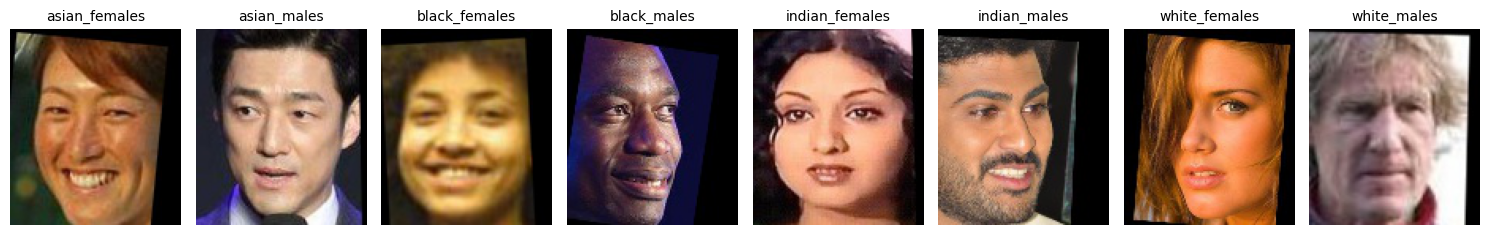

Computing mean faces: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


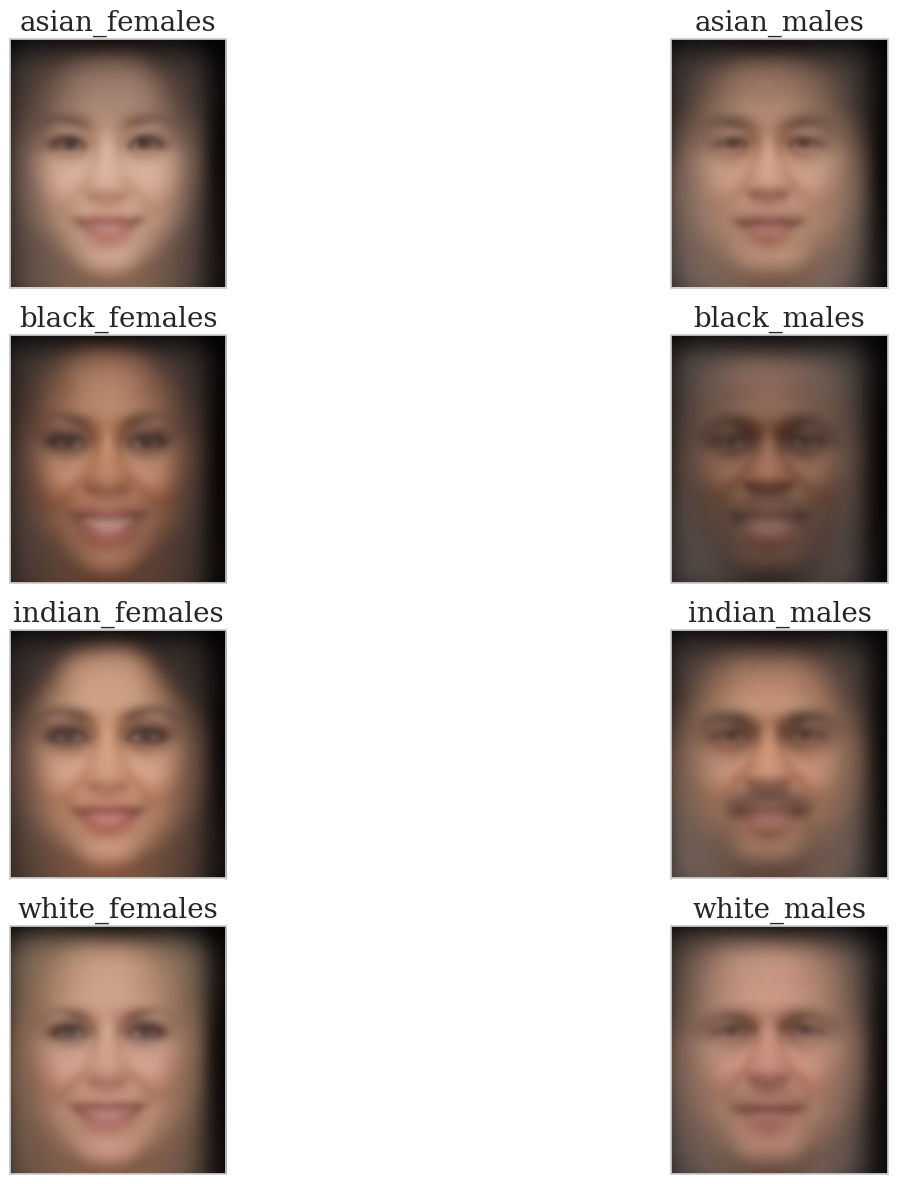

[array([[[0.04234633, 0.0368397 , 0.03668607],
         [0.04406171, 0.03836453, 0.03780364],
         [0.04694641, 0.04063319, 0.03990502],
         ...,
         [0.01480951, 0.01251964, 0.01231189],
         [0.0138348 , 0.01160839, 0.01156534],
         [0.01309172, 0.01082103, 0.01077042]],
 
        [[0.04713943, 0.04143549, 0.04057959],
         [0.04893849, 0.04305149, 0.04173973],
         [0.0531593 , 0.04655541, 0.04515948],
         ...,
         [0.01653004, 0.01424578, 0.0139087 ],
         [0.01537345, 0.01313306, 0.01289548],
         [0.01430863, 0.01203868, 0.01183158]],
 
        [[0.05460624, 0.04821336, 0.04697866],
         [0.05685142, 0.05012482, 0.04845243],
         [0.06198005, 0.05445703, 0.05269836],
         ...,
         [0.01833767, 0.01595481, 0.01552372],
         [0.01664415, 0.01431891, 0.01399428],
         [0.01527617, 0.01290634, 0.01264164]],
 
        ...,
 
        [[0.22883984, 0.19043134, 0.17443298],
         [0.24462602, 0.20432176, 0.18736

In [2]:
results_DIR = config.DATA_DIR

# Or step-by-step
analyzer = FaceDatasetAnalyzer(results_DIR)
analyzer.print_classes()
analyzer.print_class_distribution()
analyzer.print_dimension_stats()
analyzer.plot_sample_images()
analyzer.plot_mean_faces()

In [3]:
classes = load_classes(results_DIR)

# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model(len(classes), "face_classifier_resnet18.pth", device)

# Summarize model
summarize_model(model)

# Load validation loader
val_loader, _ = get_val_loader(results_DIR, "val_indices.pt")

# Evaluate fairness
results = evaluate_fairness(model, val_loader, classes, device)

/Users/admin/Documents/Hertie/Deep Learning/tutorial-new-grp5/src/bias_assessment.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_loc

In [10]:
results


{'overall_accuracy': 81.5,
 'per_class_accuracy': {'asian_females': 85.27724665391969,
  'asian_males': 77.03252032520325,
  'black_females': 79.11392405063292,
  'black_males': 91.699604743083,
  'indian_females': 81.05263157894737,
  'indian_males': 82.97029702970296,
  'white_females': 77.60617760617761,
  'white_males': 76.92307692307693},
 'accuracy_std_dev': np.float64(4.775066590959484),
 'precision': {'asian_females': 84.79087452471484,
  'asian_males': 75.64870259481037,
  'black_females': 79.44915254237289,
  'black_males': 81.54657293497364,
  'indian_females': 82.08955223880598,
  'indian_males': 79.20604914933837,
  'white_females': 88.1578947368421,
  'white_males': 81.58995815899581},
 'macro_precision': 81.55984461010675,
 'recall': {'asian_females': 85.27724665391969,
  'asian_males': 77.03252032520325,
  'black_females': 79.11392405063292,
  'black_males': 91.699604743083,
  'indian_females': 81.05263157894737,
  'indian_males': 82.97029702970296,
  'white_females': 7

## Fairness Evaluation 

First, we'll take a look at the common metrics to evaluate classification problems. How does precision, accuracy and f1 vary across groups? 

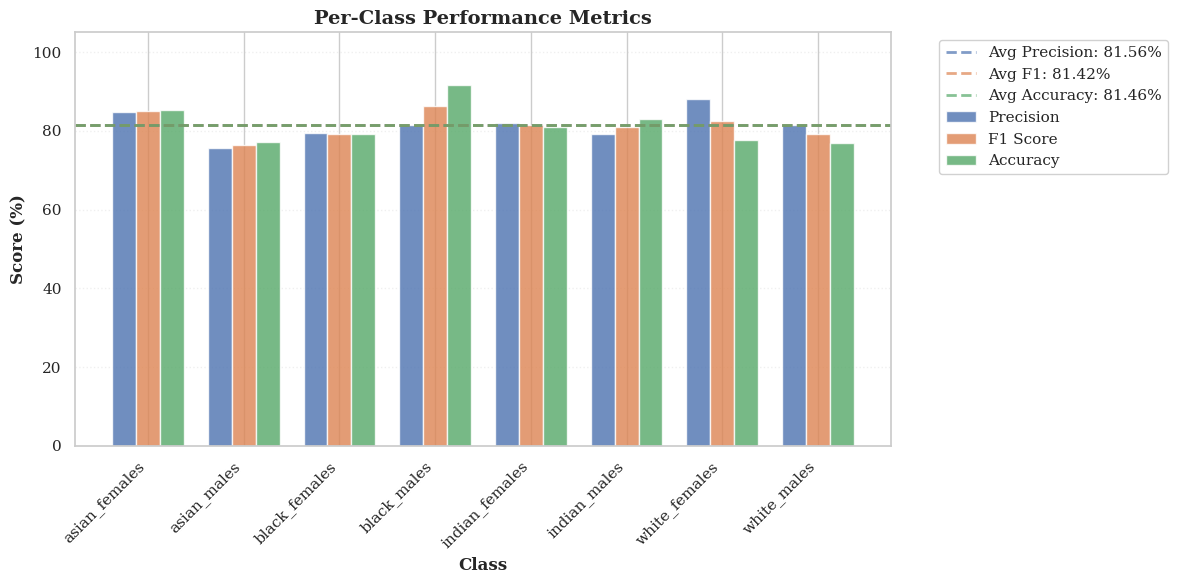

In [ ]:
plot_acc_prec_f1_metrics(results, classes)

However, looking at only these regular metrics is not enough to make a thorough assessment on fairness of the model. There are different other metrics that measure this, which are more useful to identify a model's bias. In the `evaluate_fairness` function, we also compute: 

- **Demographic Parity:** The rate at which the model makes positive predictions for each group, regardless of ground truth.
    - `positive_predictions / total_samples` for each group
    -  **ideal case:** all groups have same similar positive prediction rates. 
- Equal Opportunity (TPR): Among individuals who actually belong to the positive class, what percentage does the model correctly identify?
    - ` true_positives / (true_positives + false_negatives)` for each group
    - **ideal case:** all groups should have similar TPR.
- **Individual Fairness Proxy (Embedding Distance):** The average distance between feature representations (embeddings) of samples within each group, measuring how similarly the model internally represents individuals from the same group.
    - `average(||embedding_i - embedding_j||)` for all pairs (i,j) within each group
    - **ideal case:** all groups should have similar average embedding distances, indicating the model recognizes comparable levels of individual variation across groups and doesn't stereotype or homogenize any particular group.

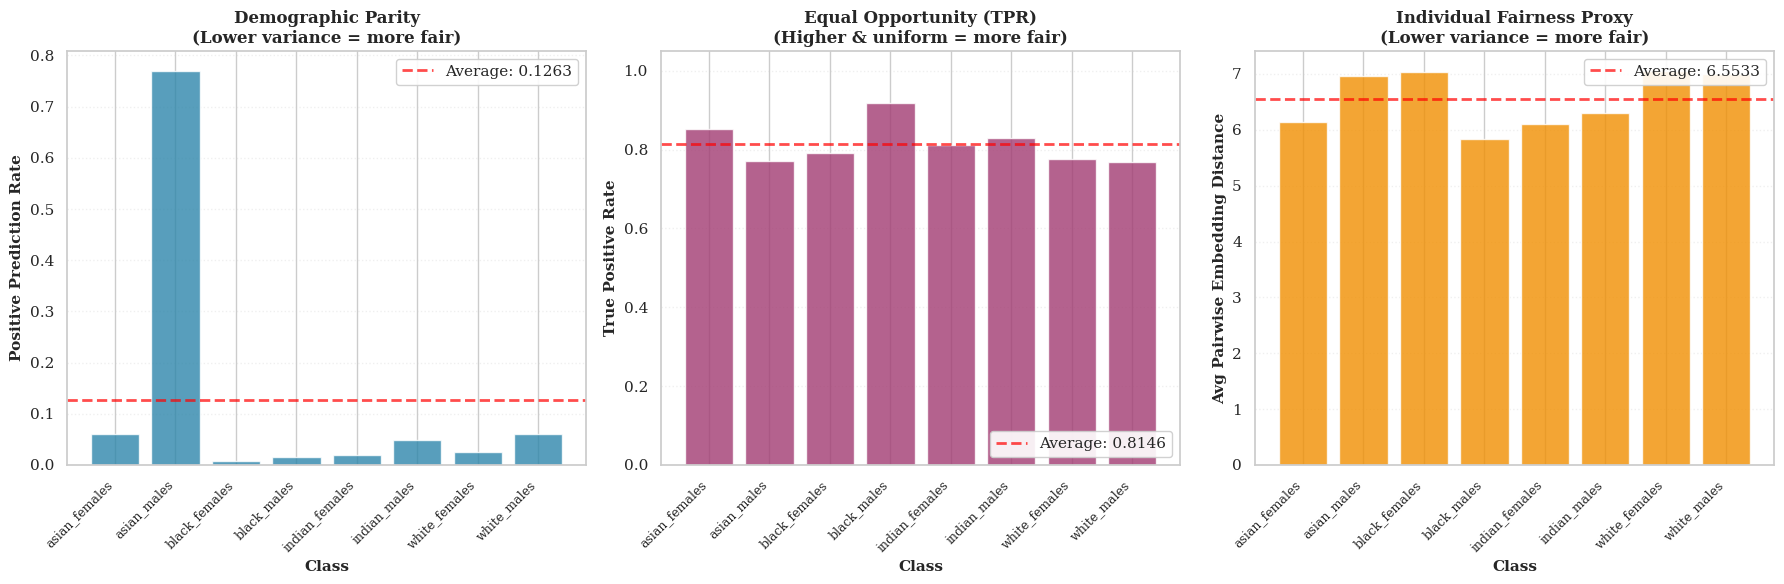


FAIRNESS METRICS SUMMARY

Demographic Parity:
  Mean: 0.1263
  Std Dev: 0.2442
  Range: [0.0084, 0.7703]

Equal Opportunity (TPR):
  Mean: 0.8146
  Std Dev: 0.0478
  Range: [0.7692, 0.9170]

Individual Fairness Proxy:
  Mean: 6.5533
  Std Dev: 0.4762
  Range: [5.8325, 7.0589]



In [ ]:
plot_bias_fairness_metrics(results, classes)

# **Fairness & Bias Summary**

## **Overall Performance**
- **Accuracy:** 81.5%  
- **Macro F1:** 81.4%  
- Moderate variation across groups (**std dev ≈ 4.8**).

---

## **Key Bias Findings**

### **1. Performance Disparities**
- **Highest-performing group:** **Black males** (Accuracy 91.7%, F1 86.3).  
- **Lowest-performing groups:**  
  - **Asian males** (Accuracy 77.0%, F1 76.3)  
  - **White males** (Accuracy 76.9%, F1 79.2)  
  - **White females** (Accuracy 77.6%)  
- **Gap:** ~15 percentage points between best and worst → **significant accuracy disparity**.

---

### **2. Demographic Parity (DP)**
- Most groups: DP ≈ **0.01–0.08**  
- **Asian males:** **0.77** → **severe violation**, model heavily over-predicts positives for this group.

---

### **3. Equal Opportunity (TPR)**
- High TPR: **Black males (0.917)**, **Asian females (0.853)**  
- Lower TPR: **White males (0.769)**, **Asian males (0.770)**  
- Indicates **unequal true positive rates** across groups.

---

### **4. Individual Fairness Proxy**
- Best (lowest score): **Black males (≈5.83)**  
- Worst: **White females / Black females (≈7.05)**  
- Suggests **greater per-individual inconsistency** for some groups.

---

## **Overall Verdict**
The model shows **clear fairness issues**:  
- Major **Demographic Parity violation** (especially Asian males)  
- Significant **Equal Opportunity gaps**  
- Noticeable **accuracy and F1 disparities**  
- Evidence of **individual unfairness**

**Conclusion:** The model is **not fair** and exhibits **systematic group-level bias**.
